In [4]:
import sys; sys.path.append("..")
from model import ELM2D
from wrapper import KS2DModelWrapper
import torch 
import numpy as np

torch.set_grad_enabled(False)
torch.manual_seed(10)

d = torch.tensor(np.load(("ks2d_short.npy")))
X_train, Y_train = d[:2,None,:,:]
X_test, Y_test = d[-2:,None,:,:]
N0, N1 = d.shape[1:]

In [5]:
from tqdm.notebook import tqdm 

extent = 2
step = 4
hidden = 400 
errors_one_symmetry = [[] for _ in range(8)]

model = KS2DModelWrapper(ELM2D((extent,extent),(step,step),hidden))
symmetries = list(range(8))
pbar = tqdm(symmetries)

def RSE(X,Y):
    return 100 * (X - Y).pow(2).mean() / (Y - Y.mean()).pow(2).mean()

def callback(k, model, sym):
    Y_pred = model(X_test, nr_symmetries=1)
    err = RSE(Y_pred, Y_test)
    errors_one_symmetry[sym].append(err.item())
    pbar.set_description(f"{errors_one_symmetry[sym][-1]:.5f}")

model_one_symmetry = None
for sym in pbar:
    cb = lambda k,_, model: callback(k, model, sym)
    model.train(X_train, Y_train, nr_symmetries=sym+1, stopping_threshold=1e-3, noise=1e-5, callback=cb)
    if sym == 0: model_one_symmetry = model

  0%|          | 0/8 [00:00<?, ?it/s]

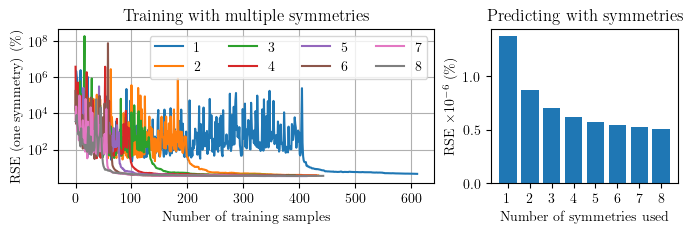

In [3]:
import matplotlib.pyplot as plt 
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

fig, ax = plt.subplots(1,2,figsize=(8,2),width_ratios=[1,0.5],gridspec_kw={"wspace":.2})
for sym, r in enumerate(errors_one_symmetry):
    x = np.arange(len(r))
    ax[0].plot(x, np.array(r), label=f"{sym+1}")
ax[0].set_yscale("log")
ax[0].legend(ncols=4)
ax[0].set_ylabel("RSE (one symmetry) (\%)")
ax[0].set_xlabel("Number of training samples")
ax[0].set_title("Training with multiple symmetries")
ax[0].grid()

errors_by_symmetries = []
for sym in range(8):    
    Y_pred = model_one_symmetry(X_test, nr_symmetries=sym+1).detach()
    err = RSE(Y_pred, Y_test)
    errors_by_symmetries.append(err.item() * 10**6)

#print(errors_one_symmetry[-3][-1])

ax[1].bar(x=[i+1 for i in range(8)],height=errors_by_symmetries)
ax[1].set_ylabel("RSE $\\times 10^{-6}$ (\%)")
ax[1].set_xlabel("Number of symmetries used")
ax[1].set_xticks([i+1 for i in range(8)])
ax[1].set_title("Predicting with symmetries")

plt.savefig("plots/ks2d_symmetries.pdf", format="pdf", bbox_inches="tight")
plt.show()